<a href="https://colab.research.google.com/github/orioncua21/Smart-Estate/blob/main/SmartEstate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Orion Cua

Project Group 12

CS 482

Smart Estate - Predicting Housing Sale Prices

**Overview:**

The purpose of this project is to predict the sale prices of houses given nearly 80 variables describing the home. Ultimately, we will be using a Random Forest method to predict the sale prices. Along the way, I will be showcasing the benefits of JAX and how it can be used in a machine learning environment.

For this project, we will import jax.numpy, as this is what we will be showcasing in this project. We will also import the pandas package to import and manipulate the dataset. Matplotlib and seaborn will be used to make graphs and visualizations of the data.

For this project, I will be importing the data from google drive.

In [ ]:
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
!pip install fast_ml
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Before we get started on the Kaggle competition data, I will demonstrate some of the capabilities of JAX in python.

First, we will create a random uniform matrix. In this case, the size will be 7,500 x 7,500. We make the array large to demonstrate the efficiency of jax vs numpy.

In [ ]:
from jax import random

key = random.PRNGKey(0)
jax_matrix = random.uniform(key, (7500,7500), minval=0, maxval=100)
numpy_matrix = np.random.uniform(low=0, high = 100, size=(7500,7500))

We will attempt to do some calculations on this large array and time it to test the difference between the numpy and jax arrays. First, we will do numpy calculations.

In [ ]:
def np_squared_mult_mean(x):
  squared = np.square(x)
  result = np.dot(squared, squared.T).mean()
  print(result)
  return result

%time np_squared_mult_mean(numpy_matrix)

83337333096.06104
CPU times: user 22.5 s, sys: 1.7 s, total: 24.2 s
Wall time: 23.2 s


83337333096.06104

As you can see, it takes about 23.2 seconds to compute. Now let's try it with JAX.

In [ ]:
from jax import jit
def jax_squared_mult_mean(x):
  squared = jnp.square(x)
  result = jnp.dot(squared, squared.T).mean()
  print(result)
  return result

jit_jax_squared_mult_mean = jit(jax_squared_mult_mean)
%time jit_jax_squared_mult_mean(jax_matrix)

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
CPU times: user 26.6 s, sys: 33.6 ms, total: 26.6 s
Wall time: 13.9 s


DeviceArray(8.3375915e+10, dtype=float32)

We can see that the if we include the jit package from jax, that the time is significantly reduced. Something like this is extremely pivital in machine learning and data science, since there will be very larg datasets and multiple operations that take place. Reducing a few seconds off of an operation can mean incredible improvement in efficiency. This is only the surface of the capabilities of JAX, and we will use it further when using it on a Decision Tree implementation to solve a Kaggle Competition problem.

The Kaggle competition tasks us to predict the sales price of a set of houses. We are given nearly 80 variables that will describe each property and will help us to determine the price. There are many ways to predict the prices, but I will be implementing a Random Forest method to predict the prices.

The test and train files are located in my google drive, which I connected with this file and was therefore able to locate and import. I will read the datasets into Colab using pandas.

In [ ]:
%cd /gdrive
test_file = r'/gdrive/MyDrive/Colab Notebooks/test.csv'
train_file = r'/gdrive/MyDrive/Colab Notebooks/train.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

/gdrive


The first step is to clean the data using our knowledge, research and analytics.

We will drop the ID column from both datasets since it is not a variable that will factor into the sale price. We will save the ID from the test set, as we will need to combine it with the predicted sale price at the end.

In [ ]:
train_data.drop(["Id"], axis=1)

Test_IDs = test_data["Id"]
test_data.drop(["Id"], axis=1)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,GarageFinish,GarageCars,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,SaleType,SaleCondition
0,20,RH,80.0,11622,Reg,Lvl,Inside,NAmes,Feedr,1Fam,...,Unf,1.0,730.0,TA,140,0,0,120,WD,Normal
1,20,RL,81.0,14267,IR1,Lvl,Corner,NAmes,Norm,1Fam,...,Unf,1.0,312.0,TA,393,36,0,0,WD,Normal
2,60,RL,74.0,13830,IR1,Lvl,Inside,Gilbert,Norm,1Fam,...,Fin,2.0,482.0,TA,212,34,0,0,WD,Normal
3,60,RL,78.0,9978,IR1,Lvl,Inside,Gilbert,Norm,1Fam,...,Fin,2.0,470.0,TA,360,36,0,0,WD,Normal
4,120,RL,43.0,5005,IR1,HLS,Inside,StoneBr,Norm,TwnhsE,...,RFn,2.0,506.0,TA,0,82,0,144,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Reg,Lvl,Inside,MeadowV,Norm,Twnhs,...,NaN,0.0,0.0,NaN,0,0,0,0,WD,Normal
1455,160,RM,21.0,1894,Reg,Lvl,Inside,MeadowV,Norm,TwnhsE,...,Unf,1.0,286.0,TA,0,24,0,0,WD,Abnorml
1456,20,RL,160.0,20000,Reg,Lvl,Inside,Mitchel,Norm,1Fam,...,Unf,2.0,576.0,TA,474,0,0,0,WD,Abnorml
1457,85,RL,62.0,10441,Reg,Lvl,Inside,Mitchel,Norm,1Fam,...,NaN,0.0,0.0,NaN,80,32,0,0,WD,Normal


Although there are many different variables, there are some that are almost entire null. We will get rid of those variables, as it has not use to our predictions.

In [ ]:
empty_cols = train_data.isna().sum().reset_index(drop=False)
empty_cols.columns = ["column","rows"]
empty_cols["missing_pct"] = (empty_cols["rows"]/train_data.shape[0])*100
empty_cols = empty_cols[empty_cols["rows"]>500].sort_values(by="missing_pct",ascending=False)
empty = empty_cols['column'].tolist()
train_data.drop(empty, axis=1, inplace=True)
test_data.drop(empty, axis=1, inplace=True)
print("Dropping the following empty columns: ", empty)

Dropping the following empty columns:  ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']


Cleaning of Numerical Data

I will import a package called fast_ml to easily find constant variables. These are variables where 95% or more of the values are identical. We will drop these variables because since they are all the same, it is reasonable to assume that they will have little to no impact on the sales price.

In [ ]:
train_numerical_cols = train_data.select_dtypes(exclude=["object"])
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(train_numerical_cols, threshold=0.95, dropna=False)
constant_features_list = constant_features['Var'].to_list()
print("Dropping the following constant columns: ", constant_features_list)
train_data.drop(constant_features_list, axis=1, inplace=True)
test_data.drop(constant_features_list, axis=1, inplace=True)

Dropping the following constant columns:  ['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal', 'KitchenAbvGr']


Finding the Correlation Between the Numerical Data and Sales Price

We will use the functionality with pandas to identify which variables are highly correlated with the sales price. This will give us insight into which variables impact sales price the most.

In [ ]:
correlation_matrix = train_data.select_dtypes(exclude=["object"]).corr()
corr = correlation_matrix["SalePrice"].sort_values(ascending = False)
print(corr)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
MoSold           0.046432
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
Id              -0.021917
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64


From this data, we can see that the number one variable that directly correlates to the sales price is the overall quality of the property, which makes sense. Other highly correlated variables include GrLivArea, which is the square footage of the above ground living area, GarageCars, which states how many cars fit in the garage. The variables that were least correlated include BsmtHalfBath, which indicates the number of half baths a basement has, and the month and year that the house was sold.

Next, we will visualize the highly correlated variables in a graph.

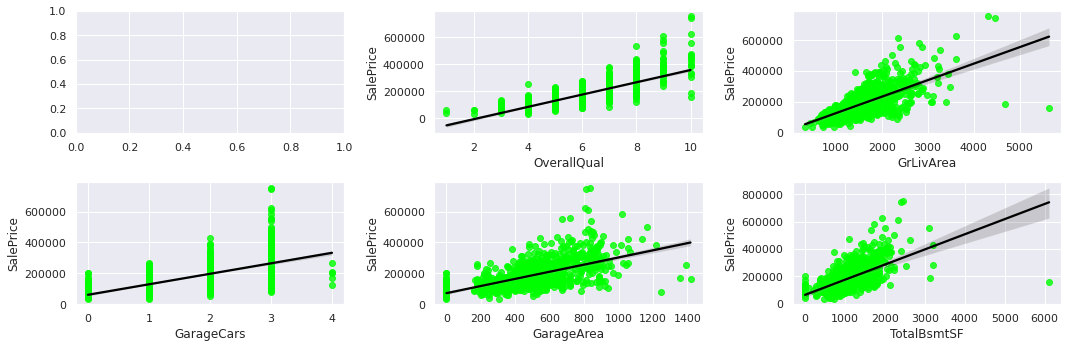

In [ ]:
high_corr = corr[:6].index.tolist()
df_high_corr = train_data.loc[:, high_corr]
sns.set(rc={"figure.figsize": (15, 5)})
fig, ax = plt.subplots(2, 3)
for i, ax in enumerate(fig.axes):
    if i > 0:
      sns.regplot(x=high_corr[i], y="SalePrice", data=df_high_corr, ax=ax, scatter_kws={"color": "lime"}, line_kws={"color": "black"})
plt.tight_layout()

From these graph, we are able to visualize the positive correlation of these graphs. As we can see, typically the higher the overall quality of the house, the higher the sale price.

Next, after carefully reviewing the list of correlations and quantitative data, I have decided to drop a few that have no correlation both based on the data and based on my previous knowledge and research.

In [ ]:
no_corr_columns = ['MoSold', 'YrSold', 'BsmtFinSF2']
train_data.drop(no_corr_columns, axis=1, inplace=True)
test_data.drop(no_corr_columns, axis=1, inplace=True)
print("Dropping the following columns that have no correlation to sales price: ", no_corr_columns)

Dropping the following columns that have no correlation to sales price:  ['MoSold', 'YrSold', 'BsmtFinSF2']


Let's take a look at which numerical quantitative data we have remaining.

In [ ]:
numerical_cols = train_data.select_dtypes(exclude=["object"])
print("Remaining numerical columns: ", numerical_cols.columns)

Remaining numerical columns:  Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
       'SalePrice'],
      dtype='object')


Now that we have worked on the numerical quantitative data, we will move onto the categorical data given in the dataset. First, we will seek out the categorial variables that don't have a lot of unique values. If all the values are the same, then the value itself won't have an impact on the final sales price.

In [ ]:
train_object_cols = train_data.select_dtypes(include=['object'])
constant_features = get_constant_features(train_object_cols, threshold=0.90, dropna=False)
constant_features_list = constant_features['Var'].to_list()
train_data.drop(constant_features_list, axis=1, inplace=True)
test_data.drop(constant_features_list, axis=1, inplace=True)
print("Dropping the following constant columns: ", constant_features_list)

Dropping the following constant columns:  ['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'LandSlope', 'CentralAir', 'Functional', 'PavedDrive', 'Electrical', 'GarageCond']


The next step is to fill up the remaining NA values within each column to make it easier to analyze the data. To simplify things, we will just fill the NA values withe the most common occurrence, or the mode. Once we get rid of the NAs, we will be using one hot encoding to make the categorical data easier to analyze.

In [ ]:
train_object_cols = train_data.select_dtypes(include=['object'])
train_object_cols = train_object_cols.fillna(train_object_cols.mode().iloc[0])
train_object_cols = pd.get_dummies(train_object_cols, columns=train_object_cols.columns)
test_object_cols = test_data.select_dtypes(include=['object'])
test_object_cols = test_object_cols.fillna(test_object_cols.mode().iloc[0])
test_object_cols = pd.get_dummies(test_object_cols, columns=test_object_cols.columns) 

We can now analyze the correlation between sales price and the categorical variables.

In [ ]:
train_object_cols["SalePrice"] = train_data["SalePrice"]
train_object_corr=train_object_cols.corr()
corr = train_object_corr["SalePrice"].sort_values(ascending=False)
print(corr)

SalePrice           1.000000
BsmtQual_Ex         0.553105
KitchenQual_Ex      0.504094
Foundation_PConc    0.497734
ExterQual_Gd        0.452466
                      ...   
MasVnrType_None    -0.367456
BsmtQual_TA        -0.498545
GarageFinish_Unf   -0.513906
KitchenQual_TA     -0.519298
ExterQual_TA       -0.589044
Name: SalePrice, Length: 184, dtype: float64


We can see that the categorical data have some positive and negative correlations with the sales price.

Now that all the data has been prepped and cleaned, we will combine the relevant information so we have the clean data in a test and train dataset.

In [ ]:
train_numerical_vars = train_data.select_dtypes(exclude=["object"])
test_numerical_vars = test_data.select_dtypes(exclude=["object"])

train_df = pd.concat([train_numerical_vars, train_object_cols], axis=1).drop_duplicates()
test_df = pd.concat([test_numerical_vars, test_object_cols], axis=1).drop_duplicates()
train_x = train_df.loc[:, train_df.columns != 'SalePrice']
train_y = train_df.loc[:, train_df.columns == 'SalePrice']
train_y = train_y.iloc[: , 1:]

We will not move onto creating the Random Forest model. The first step is to create a DecisionTree class. 

The DecisionTree class will have an x, which represents the x values, or the variables, a y which represents the sales price, a depth of the tree so we can navigate through each node and a max depth that will serve as a stopper.

Within the DecisionTree class, will will first make a function that will find the best variable and threshold to split on. In order to split the tree into nodes, we must find the optimal criteria that will minimize the RSS. We will create a function called find_criteria that will parse through all the posible variables that we can split on and check each possible threshold for those variables to find the one that will minimize the RSS. The RSS formula is:

$\sum_{i=1}^{n} (y_i-f(x_i))^2$

We will calculate the sum of the rss value of the left node and the rss value of the second node to compute the total rss. Here, we will implore the use of Jax as an alternative to numpy, and will be used to do calculations such as sum and mean. Using jax in this setting will help to speed up the computation, as this operation will be called numerous times during the learning process.

The split_tree function will recursively build out the tree by finding a criteria that will work best to split each node until the max depth is reached.

We also need a function that will compute the predictions. The predict function will parse the input variables through the tree and will provide a prediction based on the rules of the tree that were assigned when it was being built.

In [ ]:
class DecisionTree:
    def __init__(self, x_values, y_values, depth=0, max_depth=3):
        
        self.x_values = x_values #A list of values for each variable
        self.y_values = y_values #The sales price associated with the variables
        self.depth = depth #The current depth of the tree
        self.max_depth = max_depth #The maximum depth of the tree
        self.split_tree(self.x_values, self.y_values, self.depth, self.max_depth)

    def find_criteria(self, x_values, y_values): #Find the ideal criteria on which we can split the tree
        target_var = None
        target_threshold = None
        min_rss = float("inf")
        
        for var in x_values.columns: #Check through each variable to find the ideal variable that will minimize the RSS
            thresholds = np.array(x_values[var].unique())
            for threshold in thresholds: #For each variable, check each threshold to find the ideal one
                left_y_ix = x_values[var] < threshold
                left_y_np = y_values[left_y_ix].to_numpy() #Store the values less than the threshold and convert to a numpy array for easy jax computations
                right_y_np = y_values[~left_y_ix].to_numpy() #Store the values greater than the threshold and convert to a numpy array for easy jax computations
                trss = jax.numpy.sum((left_y_np-jax.numpy.mean(left_y_np))**2) + jax.numpy.sum((right_y_np-jax.numpy.mean(right_y_np))**2) #Calculate the RSS to see if it is ideal
                if trss < min_rss: #Find the minimum RSS for all thresholds in all variables
                    min_rss = trss
                    target_threshold = threshold
                    target_var = var
        return {'Column': target_var, 'Threshold': target_threshold} #Return a dict to indicate the idea variable and threshold for that variable
            
   
    def split_tree(self, x_values, y_values, depth, max_depth): #We will split the tree into two decision nodes using the criteria
        if(depth == max_depth or len(x_values) < 2):
            return {'Prediction': np.mean(y_values)}
        treeRule = self.find_criteria(x_values, y_values) #Find the ideal variable and threshold to split on
        left_ix = x_values[treeRule['Column']] < treeRule['Threshold'] 
        
        treeRule['left'] = self.split_tree(x_values[left_ix], y_values[left_ix], depth+1, max_depth) #Recursively split the left node containing elements to the left of the threshold
       
        treeRule['right'] = self.split_tree(x_values[~left_ix], y_values[~left_ix], depth+1, max_depth) #Recursively split the right node containing elements to the right of the threshold
        
        self.treeRules = treeRule
        
        return treeRule #Return the fully created tree that has multiple decision nodes
  
    def predict(self, s, treeRules): # Predict the price given the x variables
        prediction = None
        while prediction is None:
            Column = treeRules['Column']
            Threshold = treeRules['Threshold']
            if(s[Column] < Threshold): #Check if the chosen variable of the node is less than or greater than the threshold
                treeRules = treeRules['left']
            else:
                treeRules = treeRules['right']
            prediction = treeRules.get('Prediction', None)
        return prediction
        
    def tree_prediction(self, x_values): #Traverse the nodes to find the predicted price
        predictions = x_values.apply(self.predict, axis=1, treeRules = self.treeRules) #Get the predictions by calling the predict function for each x value
        return predictions

Now that the DecisionTree class is completed, we can move onto creating the Random Forest that will utilize a number of DecisionTrees to find the best results.

The build_tree function will be used to create DecisionTree objects.

The build_forest function will populate the forest with a specified number of DecisionTree objects.

The make_prediction function will predict the final sale prices.

In [ ]:
class RandomForest():   
    def __init__(self, n, max_depth =3, bootstrap=0.9):
        self.n = n #Number of trees we will have in the forest
        self.max_depth = max_depth #Maximum depth of each tree in the forest
        self.bootstrap = bootstrap

    def bootstrap_sample(self, x_values, y_values):
        return np.random.randint(len(x_values), size=int(len(x_values)*self.bootstrap))

    def build_tree(self, x_values, y_values): #Create a DecisionTree object using random input data
        random_vals = self.bootstrap_sample(x_values,y_values) #Create random input data from the given values
        return DecisionTree(x_values.iloc[random_vals], y_values.iloc[random_vals], depth = 0, max_depth = self.max_depth) #Create a DecisionTree object with the random input

    def build_forest(self, x_values, y_values): #Create n number of trees to populate the forest
        self.DecisionTrees = [] #List of DecisionTree objects in the forest
        for i in range(self.n):
          self.DecisionTrees.append(self.build_tree(x_values, y_values)) #Populate the forest and append each DecisionTree object to the list
        print("Forest created successfully")
        return self.DecisionTrees
    def make_prediction(self, x): #Find the predictions of each tree and output the mean of each prediction
        results = [] #Store the sales price predictions in an array
        for tree in self.DecisionTrees:
            results.append(tree.tree_prediction(x)) #For each tree, find the predicted sales price
        final_results = np.mean(results, axis=0) #Get the average of all the DecisionTree predictions to get the final prediction for the forest
        return final_results

In order to test the results of the algorithm, we will use Mean Squared Error (MSE). MSE will calculate the amount of error in the prediction vs. the actual value. The formula for MSE is:

$MSE = \frac{1} {n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2$

We will create a python function that will utilize jax to quickly do the calculations.

In [ ]:
def MSE(y_pred, y_actual): #Calculate the Mean Squared Error for the predicted sales price and actual sales price
  error = jax.numpy.subtract(y_pred,y_actual)
  squared_error = jax.numpy.square(error)
  sum_squared_error = np.sum(squared_error)
  mean_squared_error = sum_squared_error/y_pred.size
  return mean_squared_error

We are now ready to test the effectiveness of our Decision Tree and Random Forest models. To do so, we will split the training dataset into two parts, one of which will be the training set and the other a test set. We have to break down the training dataset because it is the only set that includes the sales prices. We will perform a 75-25 split, which means that 75% of the data will be used to generate the Random Forest and 25% will be used to test the effectiveness of the predictions.

In [ ]:
train_forest = train_df.sample(frac=0.75) #The data that will be used to train the forest
test_forest = train_df.drop(train_forest.index) #The data that will be used to test the forest
train_forest_x = train_forest.loc[:, train_forest.columns != 'SalePrice'] #The variables in the dataset
train_forest_y = train_forest.loc[:, train_forest.columns == 'SalePrice'] #The sales price of the dataset

Create a RandomForest that will have 10 trees each with a max depth of 3.

In [ ]:
forest_model = RandomForest(n=10, max_depth = 3, bootstrap=0.9)
forest_model.build_forest(train_forest_x, train_forest_y)

Forest created successfully


Now that the model is created, we can use it to make predictions. Once again, we will break up the test dataset. This way, we will have the x values and also the actual y values, or the sales price, associated with the variables. This allows us to the test the predictions vs. the actual prices. Use the model to make predictions on the test x values.

In [ ]:
test_forest_x = test_forest.loc[:, test_forest.columns != 'SalePrice'] #The variables in the dataset
test_forest_y = test_forest.loc[:, test_forest.columns == 'SalePrice']
price_predictions=forest_model.make_prediction(test_forest_x)
price_predictions = price_predictions[:,0]

Let's check the MSE of the predictions vs. the actual prices. In the competition, the results are judged on Root Mean Squared Error, so we will calculate that as well.
Data Analysis:

In [ ]:
import math
price_actual = test_forest_y['SalePrice'].to_numpy()
price_actual = price_actual[:,0]
forest_model_MSE = MSE(price_predictions, price_actual)
print("MSE: ", forest_model_MSE)
print("RMSE: ", math.sqrt(forest_model_MSE))
diff = np.subtract(price_predictions, price_actual)
diff = np.absolute(diff)
average_deviation = np.sum(diff)/diff.size
print("Average Deviation: ", average_deviation)
print("Average Deviation %: ", average_deviation/price_actual.mean())

MSE:  1583266400.0
RMSE:  39790.280622282626
Average Deviation:  27465.197159346488
Average Deviation %:  0.15275596407797945


This tells us that while the MSE is very large, that is also due to the very high sales prices involved in the data. The predictions typically deviated from the actual sales price by about $27,465. This equates to about a 15% deviation from the predicted price vs. actual price.

We can now use this forest model to create our submission. The submission states that the result should be in a dataframe that has 2 columns, the ID and the sales price.

In [ ]:
final_price_predictions=forest_model.make_prediction(test_df)
final_price_predictions = final_price_predictions[:,0]
final_df = pd.DataFrame(Test_IDs, columns=['Id', 'SalePrice'])
final_df['SalePrice'] = final_price_predictions
print(final_df)

        Id      SalePrice
0     1461  122234.350559
1     1462  145220.819268
2     1463  163828.946954
3     1464  163828.946954
4     1465  252530.313580
...    ...            ...
1454  2915  116823.591790
1455  2916  116823.591790
1456  2917  146219.073801
1457  2918  120788.273540
1458  2919  225683.881930

[1459 rows x 2 columns]


This is the final result that we would be submitting into the competition.

In this program, we have utilized many techniques for data cleaning, visualization and analysis. We have also learned about the powerful tool that is JAX, which has helped us with the computations in the Random Forest machine learning algorithm.

Sources:

1) https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

2) https://jax.readthedocs.io/en/latest/jax.numpy.html

3) https://analyticsindiamag.com/how-to-speed-up-machine-learning-operations-with-jax/

4) https://www.kaggle.com/code/abdelrahmantarek13/houseprice-step-by-step

5) https://towardsdatascience.com/how-to-detect-constant-quasi-constant-features-in-your-dataset-a1ab7aea34b4

6) https://www.kaggle.com/code/lildatascientist/decision-tree-and-random-forest-from-scratch

7) https://www.kaggle.com/c/house-prices-advanced-regression-techniques

8) https://medium.com/hanman/data-modeling-building-a-house-price-prediction-model-1450f825073b